Blurred image shape: torch.Size([1, 3, 120, 120])


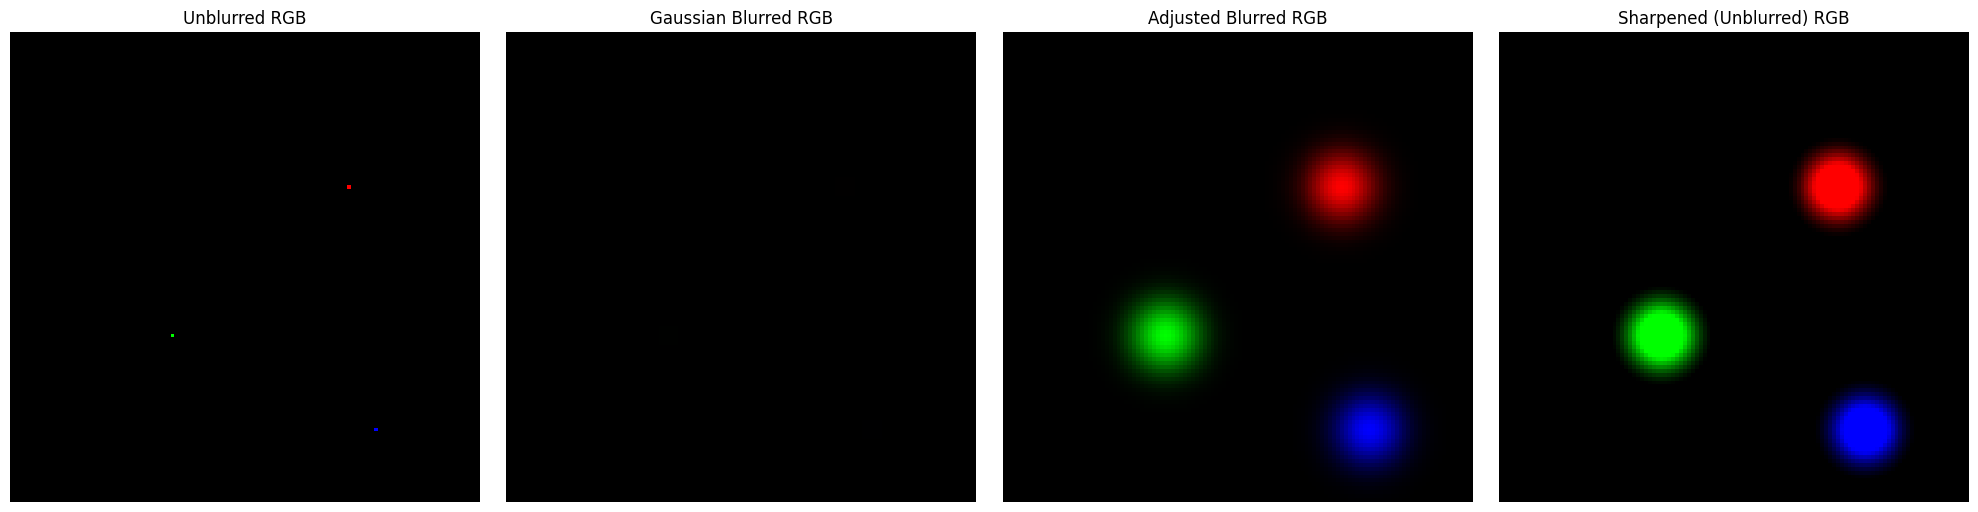

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


unblurred = torch.zeros((1, 3, 120, 120))

unblurred[0, 0, 39, 86] = 1.0   
unblurred[0, 1, 77, 41] = 1.0   
unblurred[0, 2, 101, 93] = 1.0  


def get_gaussian_kernel(kernel_size=3, sigma=1.0):
    ax = torch.arange(kernel_size, dtype=torch.float32) - kernel_size // 2
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / kernel.sum()


sigma_blur = 6
kernel_size_blur = 10 * sigma_blur + 1  
gaussian_kernel = get_gaussian_kernel(kernel_size_blur, sigma_blur)  


gaussian_kernel = gaussian_kernel.expand(3, 1, kernel_size_blur, kernel_size_blur)


padded_unblurred = F.pad(unblurred, (kernel_size_blur//2,)*4, mode='constant')

blurred = F.conv2d(padded_unblurred, gaussian_kernel, groups=3)
print("Blurred image shape:", blurred.shape)



max_info = []  

adjusted_blurred = blurred.clone()

adjusted_blurred/=torch.max(blurred)


def get_negative_gaussian_kernel(kernel_size=31, sigma=5.0, amount=1.0):
    
    
    G = get_gaussian_kernel(kernel_size, sigma)
    
    delta = torch.zeros_like(G)
    center = kernel_size // 2
    delta[center, center] = 1.0
    
    kernel = (1 + amount) * delta - amount * G
    return kernel

kernel_size_sharp = 31  
sigma_sharp = 5.0       
amount = 2.0             

sharp_kernel = get_negative_gaussian_kernel(kernel_size_sharp, sigma_sharp, amount)

sharp_kernel = sharp_kernel.expand(3, 1, kernel_size_sharp, kernel_size_sharp)


padded_adjusted = F.pad(adjusted_blurred, (kernel_size_sharp//2,)*4, mode='reflect')

unblurred_again = F.conv2d(padded_adjusted, sharp_kernel, groups=3)


    return tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

unblurred_rgb         = to_numpy(unblurred)
blurred_rgb           = to_numpy(blurred)
adjusted_blurred_rgb  = to_numpy(adjusted_blurred)
unblurred_again_rgb   = to_numpy(unblurred_again)


unblurred_rgb         = np.clip(unblurred_rgb, 0, 1)
blurred_rgb           = np.clip(blurred_rgb, 0, 1)
adjusted_blurred_rgb  = np.clip(adjusted_blurred_rgb, 0, 1)
unblurred_again_rgb   = np.clip(unblurred_again_rgb, 0, 1)



for ch, x, y, max_val, scaling in max_info:
    print(f"Channel {ch}: Max at (x={x}, y={y}) with value {max_val:.4f}; scaling factor: {scaling:.4f}")
    
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(unblurred_rgb)
axes[0].set_title('Unblurred RGB')
axes[0].axis('off')

axes[1].imshow(blurred_rgb)
axes[1].set_title('Gaussian Blurred RGB')
axes[1].axis('off')

axes[2].imshow(adjusted_blurred_rgb)
axes[2].set_title('Adjusted Blurred RGB')
axes[2].axis('off')

axes[3].imshow(unblurred_again_rgb)
axes[3].set_title('Sharpened (Unblurred) RGB')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [8]:

import torch
import torch.nn as nn
import torchvision.models as models

class PoseResNet(nn.Module):
    def __init__(self, num_deconv_layers=4, 
                 num_deconv_filters=[512, 256, 128,128],
                 num_deconv_kernels=[4, 4, 4,4],
                 num_keypoints=17):
        super(PoseResNet, self).__init__()

        
        resnet = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        # Freeze backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        
        self.deconv_layers = self._make_deconv_layer(
            num_deconv_layers, num_deconv_filters, num_deconv_kernels)
        
        self.final_layer = nn.Conv2d(
            in_channels=num_deconv_filters[-1],
            out_channels=num_keypoints,
            kernel_size=1,
            stride=1,
            padding=0
        )

    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        layers = []
        
        in_channels = 2048  
        for i in range(num_layers):
            kernel = num_kernels[i]
            out_channels = num_filters[i]
            if kernel == 4:
                padding = 1
                output_padding = 0
            elif kernel == 3:
                padding = 1
                output_padding = 1
            elif kernel == 2:
                padding = 0
                output_padding = 0
            layers.append(nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=kernel,
                stride=2, padding=padding, output_padding=output_padding, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.backbone(x)
        x = self.deconv_layers(x)
        x = self.final_layer(x)
        return x

model = PoseResNet()

trainable_params = [p for p in model.parameters() if p.requires_grad]
print("Trainable parameters count:", len(trainable_params))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 199MB/s]  


Trainable parameters count: 14


In [9]:
trainable_params = [p for p in model.parameters() if p.requires_grad]
print("Trainable parameters count:", len(trainable_params))

Trainable parameters count: 14


In [10]:
x=torch.rand((1,3,480,480))
output=model(x)
print(output.shape,output.reshape(1,17,-1).shape)

torch.Size([1, 17, 240, 240]) torch.Size([1, 17, 57600])


In [11]:
criterion = nn.MSELoss(size_average=True)
target=torch.rand(1,17,240,240).reshape(1,17,-1)
reshaped_output=output.reshape(1,17,-1)
print(criterion(reshaped_output,target))

loss=0
for i in range(17):
    loss+=criterion(reshaped_output[:,i,:],target[:,i,:])
print(loss,loss/17)

tensor(0.6273, grad_fn=<MseLossBackward0>)
tensor(10.6643, grad_fn=<AddBackward0>) tensor(0.6273, grad_fn=<DivBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [12]:

import pandas as pd
import ast  # Safer alternative to eval()


df = pd.read_csv("/kaggle/input/coco-human-keypoints-train-dataset/kaggle/working/train_keypoint_data.csv")

df.head()
df["keypoints"] = df["keypoints"].apply(ast.literal_eval)
def count_ones(keypoints):
    return sum(1 for i in range(2, len(keypoints), 3) if keypoints[i] == 1)

df_filtered = df[df["keypoints"].apply(count_ones) >= 16]#can skip this step if u have great gpu and infinite time

df.head()

df_filtered.head()
len(df),len(df_filtered),type(df_filtered["keypoints"].iloc[0]),type(df_filtered["keypoints"].iloc[0][2])

(149547, 21119, list, int)

In [13]:
class key_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion=nn.MSELoss(size_average=True)
    def forward(self,predictions,targets):
        batches=predictions.shape[0]
        # target=targets.reshape(batches,17,-1)
        # reshaped_output=predictions.reshape(batches,17,-1)
        # # print(criterion(reshaped_output,target),targets.reshape(batches,17,-1))
        # loss=0
        # for i in range(17):
        #     loss+=criterion(reshaped_output[:,i,:],target[:,i,:])
        # return loss
        if torch.isnan(predictions).any():
            print("Found NaNs inpreds!")
        if torch.isnan(targets).any():
            print("Found NaNs in target!")
        return self.criterion(predictions.reshape(batches,17,-1),targets.reshape(batches,17,-1))*100

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KeyLoss(nn.Module):
    def __init__(self, beta=100.0, scale_factor=1.0):
        
        super().__init__()
        self.beta = beta
        self.scale_factor = scale_factor
        self.criterion = nn.MSELoss(reduction='mean')

    def soft_argmax_2d(self, heatmap):
        H, W = heatmap.shape
        # Flatten the heatmap and subtract its max for numerical stability.
        flat = heatmap.view(-1)
        flat = flat - flat.max()
        # Apply softmax with temperature beta.
        if torch.isnan(flat).any():
            print("Found NaNs in flat!")
        prob = F.softmax(flat * self.beta, dim=0).view(H, W)
        
        # Create coordinate grids.
        grid_y = torch.linspace(0, H - 1, H, device=heatmap.device).view(H, 1)
        grid_x = torch.linspace(0, W - 1, W, device=heatmap.device).view(1, W)
        
        # Compute expected coordinates as weighted averages.
        x_coord = torch.sum(prob * grid_x)
        y_coord = torch.sum(prob * grid_y)
        return x_coord, y_coord

    def forward(self, predictions, targets):
        
        B, C, H, W = predictions.shape  
        total_distance = 0.0
        no_keypoint=0
        for b in range(B):
            for c in range(C):
                pred_heatmap = predictions[b, c]
                target_heatmap = targets[b, c]
                
                pred_x, pred_y = self.soft_argmax_2d(pred_heatmap)
                if torch.max(target_heatmap)==0:
                    if torch.max(pred_heatmap)>=0:
                        no_keypoint+=torch.abs(torch.sum(pred_heatmap))
                    
                # print("target")
                target_x, target_y = self.soft_argmax_2d(target_heatmap)
                
                distance = torch.sqrt((pred_x - target_x) ** 2 + (pred_y - target_y) ** 2 + 1e-6)
                total_distance += distance

        avg_distance_loss = total_distance / (B * C)
        # print(avg_distance_loss)
        mse_loss = self.criterion(predictions.reshape(B, C, -1) * 10, targets.reshape(B, C, -1) * 10)
        # print(mse_loss)
        return self.scale_factor * avg_distance_loss + mse_loss+no_keypoint/(B*C)

In [15]:
from PIL import Image
import torchvision.transforms as transforms
class human_dataset(torch.utils.data.Dataset):
    def __init__(self,dataset_pd,image_path,target_size,sigma=1):
        super().__init__()
        self.target_size=target_size
        kernel_size=sigma*10+1
        self.kernel_size=kernel_size
        self.image_path=image_path
        self.dataset_pd=dataset_pd
        self.transform = transforms.Compose([
            transforms.ToTensor()  
        ])
        gaussian_kernel = get_gaussian_kernel(kernel_size, sigma) 

        self.gaussian_kernel = gaussian_kernel.expand(17, 1, kernel_size, kernel_size)
        
        
    def __len__(self):
        return len(self.dataset_pd)
        # return 65
    def __getitem__(self,idx):
        img=Image.open(self.image_path+"/"+self.dataset_pd['image_id'].iloc[idx]).convert("RGB")
        img=self.transform(img)
        keypoints=self.dataset_pd["keypoints"].iloc[idx]
        target=torch.zeros((17,self.target_size,self.target_size))
        # need to turn the img to a tensor 
        # print(type(keypoints))
        for i in range(17):
            if keypoints[i*3+2]==1:
                target[i,int((keypoints[i*3]*(self.target_size-1))//480),int((keypoints[i*3+1]*(self.target_size-1))//480)]=1
        # code for the blur
        padded_unblurred = F.pad(target, (self.kernel_size//2,)*4, mode='constant')
        target = F.conv2d(padded_unblurred, self.gaussian_kernel, groups=17)
        

        scaling = 1 / (torch.max(target)+1e-6)
        # print(scaling)
        target*=scaling
        return img,target

In [16]:
def custom_collate_fn(batch):
    images, targets = zip(*batch) 
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets
import pandas as pd
dataset_pd=pd.read_csv("/kaggle/input/coco-human-keypoints-train-dataset/kaggle/working/train_keypoint_data.csv")
dataset = human_dataset(df_filtered,"/kaggle/input/coco-human-keypoints-train-dataset/kaggle/working/train_images",240,6)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=60, shuffle=True, collate_fn=custom_collate_fn, num_workers=4)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:# for multi gpu
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)
criterion = KeyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.8e-2)

num_epochs = 10
reduce=0.1e-4


Using 2 GPUs!


In [26]:

def load_model(filename="checkpoint.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"] 
 
def save_checkpoint(state, filename="checkpoint.pth"):
    torch.save(state, filename)

def save_model(epoch, model, optimizer, filename="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch, 
        "model_state_dict": model.state_dict(), 
        "optimizer_state_dict": optimizer.state_dict()
    }
    save_checkpoint(checkpoint, filename) 
    print("done")

epoch_loaded = load_model("checkpoint.pth")

<ipython-input-26-fa4bd1c9b8a1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [ ]:
# for param_group in optimizer.param_groups:
#     param_group['lr'] =0.7e-3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for idx,(batch_images, batch_targets) in enumerate(pbar):
        batch_images = batch_images.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        # if epoch==0 and idx==500:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] =1e-3
        running_loss += loss.item() 
        
        pbar.set_postfix({"loss": f"{running_loss/(idx+1)}"})
        del batch_images 
        del batch_targets 
        del outputs
            
        for param_group in optimizer.param_groups:
            param_group['lr'] -=reduce/150
    if epoch<=3:
        for param_group in optimizer.param_groups:
            param_group['lr'] -=2e-3
    
    save_model(1,model,optimizer,"checkpoint2.pth")

In [ ]:
import torch 




save_model(1,model,optimizer)


In [ ]:
import gc  
optimizer.zero_grad()
# Force garbage collection  
gc.collect() 
torch.cuda.empty_cache()

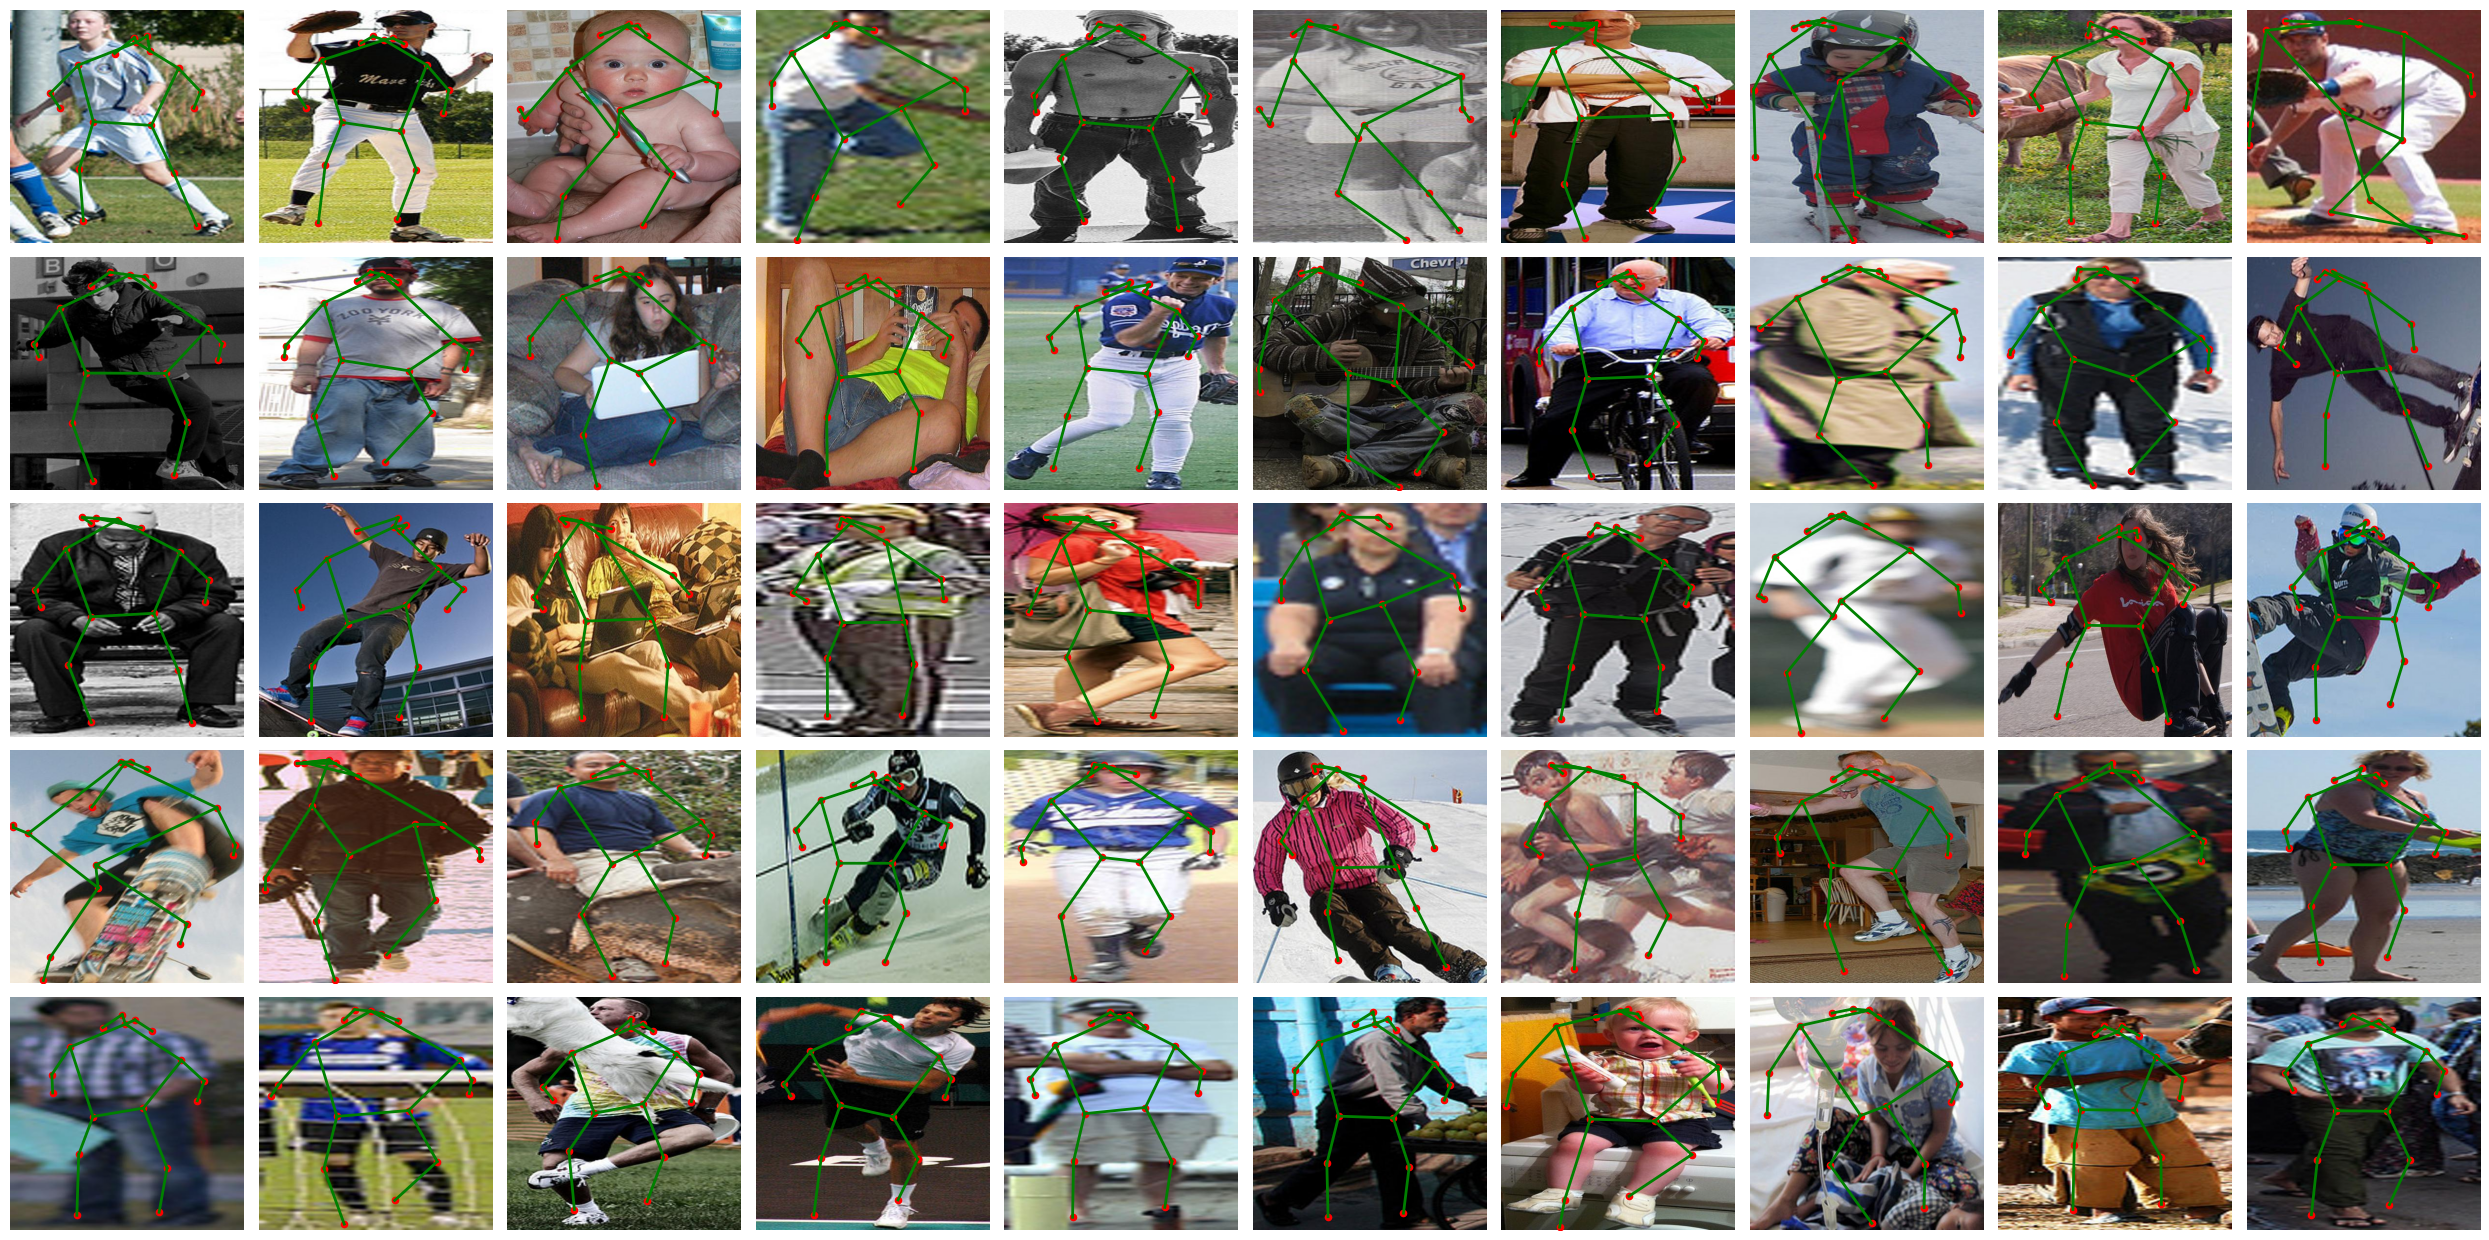

In [25]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


num_rows = 5
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
axes = axes.flatten()  # Flatten for easier indexing

for i in range(50):
    dataset_pd = df_filtered
    idx = random.randint(1, len(dataset_pd))
    img_path = '/kaggle/input/coco-human-keypoints-train-dataset/kaggle/working/train_images/' + dataset_pd["image_id"].iloc[idx]
    img = Image.open(img_path).convert('RGB')
    img = img.resize((480, 480))
    img_np = np.array(img)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        model_output = model(img_tensor)
    output = model_output[0]
    
    num_channels, H, W = output.shape
    scale_x = 480 / W
    scale_y = 480 / H
    
    def soft_argmax_2d(heatmap, beta=10.0):
        H, W = heatmap.shape
        flat = heatmap.view(-1)
        flat = flat - flat.min()
        prob = F.softmax(flat * beta, dim=0).view(H, W)
        grid_y = torch.linspace(0, H - 1, H, device=heatmap.device).view(H, 1)
        grid_x = torch.linspace(0, W - 1, W, device=heatmap.device).view(1, W)
        x_coord = torch.sum(prob * grid_x)
        y_coord = torch.sum(prob * grid_y)
        return x_coord, y_coord
    
    max_points = []
    for c in range(num_channels):
        y, x = soft_argmax_2d(output[c], beta=100.0)
        x_scaled = x * scale_x
        y_scaled = y * scale_y
        max_points.append((x_scaled, y_scaled))
    
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9),
        (6, 8), (8, 10), (5, 11), (6, 12), (11, 12), (11, 13), (13, 15),
        (12, 14), (14, 16)
    ]
    
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis("off")
    
    for idx, (x, y) in enumerate(max_points):
        x_val = x.cpu().item() if x.is_cuda else x.item()
        y_val = y.cpu().item() if y.is_cuda else y.item()
        ax.scatter(x_val, y_val, color='red', s=20)
    
    for (i, j) in skeleton:
        x1 = max_points[i][0].cpu().item() if max_points[i][0].is_cuda else max_points[i][0].item()
        y1 = max_points[i][1].cpu().item() if max_points[i][1].is_cuda else max_points[i][1].item()
        x2 = max_points[j][0].cpu().item() if max_points[j][0].is_cuda else max_points[j][0].item()
        y2 = max_points[j][1].cpu().item() if max_points[j][1].is_cuda else max_points[j][1].item()
        ax.plot([x1, x2], [y1, y2], color='green', linewidth=2)

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import FileLink

FileLink(r'checkpoint.pth')



In [ ]:
!wget -O "link to file"